In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib import rc

from train import PhysicsInformedNN

np.random.seed(1234)


In [7]:
def plot_solution(X_star, u_star, index):
    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [8]:
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))


In [12]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = scipy.io.loadmat('./data/cylinder_nektar_wake.mat')
U_star = data['U_star'] # N x 2 x T; full data of (u, v) at all x, y, t
P_star = data['p_star'] # N x T; full data of p at all x, y, t
t_star = data['t'] # T x 1; t corrdinates of the full data
X_star = data['X_star'] # N x 2; (x,y) coordinates of the full data

N = X_star.shape[0] # N=5000; size of the full data at a fixed t
T = t_star.shape[0] # T=200; size of the full data at a fixed x,y

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Training Data   
N_train = 5000 
idx = np.random.choice(N*T, N_train, replace=False) # Generate a random sample from np.arange(N*T) of size N_train without replacement
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

# Load Model
xyt_train = np.concatenate([x, y, t], 1)
pinn = PhysicsInformedNN(xyt_train, u_train, v_train, layers=3).to(device) 
path = './model/0'
load_model(pinn, path, device)


# Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

xyt_star = np.concatenate([x_star, y_star, t_star], 1)
u_pred, v_pred, p_pred, _, _ = pinn.forward(torch.FloatTensor(xyt_star))
u_pred = u_pred.detach().cpu().numpy()
v_pred = v_pred.detach().cpu().numpy()
p_pred = p_pred.detach().cpu().numpy()

lambda_1_value = pinn.lambda_1
lambda_2_value = pinn.lambda_2


# Predict for plotting
lb = X_star.min(0)  # lb = [1, -2]; smallest value of (x,y) of the fulll data
ub = X_star.max(0)  # ub = [8, 2];  largest value of (x,y) of the full data
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
    

/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


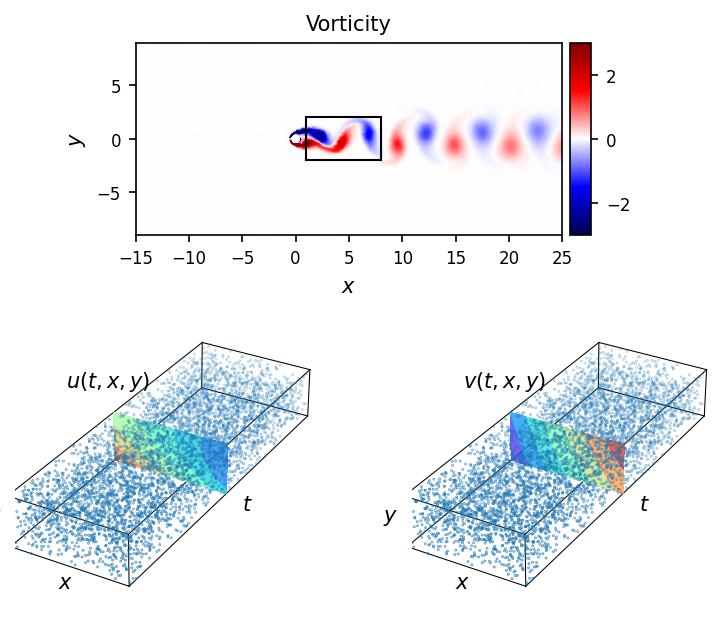

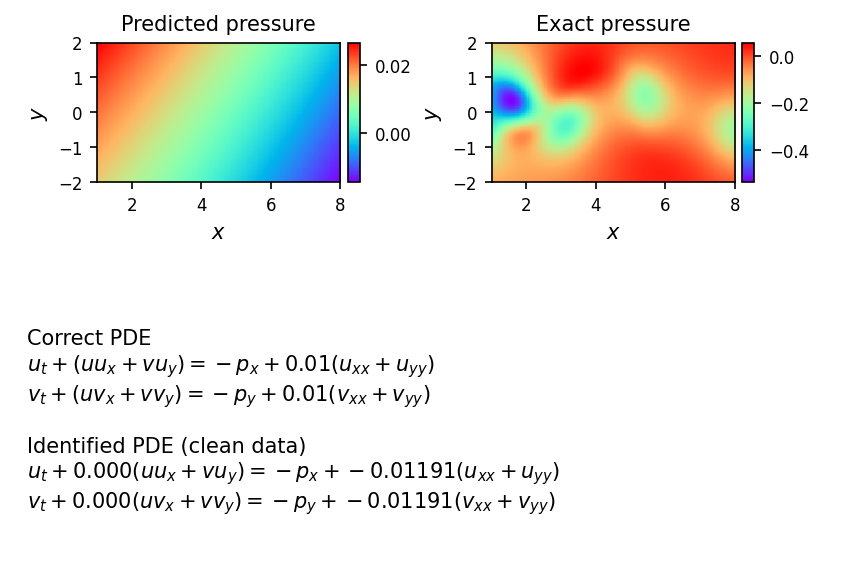

In [14]:
%matplotlib inline

rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150

######################################################################
############################# Plotting ###############################
######################################################################    
 # Load Data
data_vort = scipy.io.loadmat('./data/cylinder_nektar_t0_vorticity.mat')

x_vort = data_vort['x'] 
y_vort = data_vort['y'] 
w_vort = data_vort['w'] 
modes = np.asscalar(data_vort['modes'])
nel = np.asscalar(data_vort['nel'])    

xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')

box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])

fig, ax = newfig(1.0, 1.2)
ax.axis('off')

####### Row 0: Vorticity ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

for i in range(0, nel):
    h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Vorticity', fontsize = 10)


####### Row 1: Training data ##################
########      u(t,x,y)     ###################        
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

########      v(t,x,y)     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

# savefig('./figures/NavierStokes_data') 


fig, ax = newfig(1.015, 0.8)
ax.axis('off')

######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)


######## Row 3: Table #######################
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=1-1/2, bottom=0.0, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs3[:, :])
ax.axis('off')

s = "Correct PDE\n"
s = s + "$u_t + (u u_x + v u_y) = -p_x + 0.01 (u_{xx} + u_{yy})$\n"
s = s + "$v_t + (u v_x + v v_y) = -p_y + 0.01 (v_{xx} + v_{yy})$\n"
s = s + "\n"
s = s + "Identified PDE (clean data)\n"
s = s + "$u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})$\n" % (lambda_1_value, lambda_2_value)
s = s + "$v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})$\n" % (lambda_1_value, lambda_2_value)
s = s + "\n"
# s = s + "Identified PDE (1% noise)\n"
# s = s + "$u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})$\n" % (lambda_1_value_noisy, lambda_2_value_noisy)
# s = s + "$v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})$\n" % (lambda_1_value_noisy, lambda_2_value_noisy)
s = ax.text(0.015, -0.7, s)

# savefig('./figures/NavierStokes_prediction') 